# Property insurance risk assessment: 
using public data to estimate building features that affect insurance value


In [18]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


### Define the constant

In [19]:
IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### Pair the image label

<AxesSubplot: >

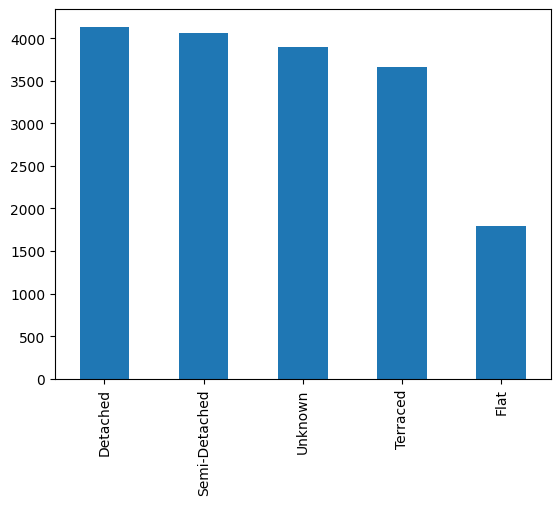

In [20]:
# loading the file name of the image
filenames = os.listdir("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view")
pro = pd.read_csv("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/properties.csv")
pro['property_id'] = 'gsv_' + pro['property_id'] + '.jpg'
pro['propertyType'].value_counts().plot.bar()

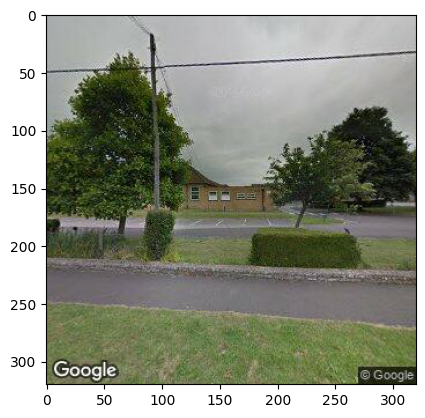

In [21]:
sample = random.choice(filenames)
image = load_img("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/"+sample)
plt.imshow(image)

### Building CNN model

In [22]:
model = Sequential()

# Convolution layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# max pool layer
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 318, 318, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 159, 159, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 159, 159, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 78, 78, 64)       